## Modelagem SEIRD

Notebook criado para testar a modelagem com base no SEIRD, principal referência: https://github.com/btseytlin/covid_peak_sir_modelling/blob/main/habr_code.ipynb

*Iniciaremos testando somente SP e depois passaremos a outros municipios


Primeira tentativa, parametros utilizados no modelo:
•	infectado_per_dia - novos casos confirmados em determinado dia, (TEMOS)
•	recovery_per_day - novos pacientes recuperados em um determinado dia,
•	death_per_day - número de mortes (por infecção) em um determinado dia, (TEMOS)
•	total_infected - número total de casos confirmados, total cumulativo de infectado por dia.
•	total_dead - número total de mortes, total cumulativo de mortes_por_dia.
•	total_recovered - número total de pacientes recuperados, total cumulativo de recovery_per_day.


In [178]:
import pandas as pd

In [179]:
covid_cases = pd.read_csv(r"C:\Users\mscamargo\Desktop\estudos\my_proj\covid19_previsoes_municipios\data\mariana.csv")
covid_cases.data = pd.to_datetime(covid_cases.data)

In [180]:
covid_cases.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,...,interior/metropolitana,mes,ano,semana_ano,mes_ano,taxa_de_letalidade,media_movel_casos,media_movel_obitos,media_movel_letalidade,acumulado_casos_ultimos_20d
0,Sudeste,SP,São Paulo,35,355030.0,35016.0,SAO PAULO,2020-03-27,13,12252023.0,...,1.0,3,2020,202013,202003,0.000000,0.000000,0.000000,0.000000,0.000000
1,Sudeste,SP,São Paulo,35,355030.0,35016.0,SAO PAULO,2020-03-28,13,12252023.0,...,1.0,3,2020,202013,202003,0.066144,574.500000,38.000000,0.033072,574.500000
2,Sudeste,SP,São Paulo,35,355030.0,35016.0,SAO PAULO,2020-03-29,14,12252023.0,...,1.0,3,2020,202014,202003,0.075232,394.333333,29.666667,0.047126,394.333333
3,Sudeste,SP,São Paulo,35,355030.0,35016.0,SAO PAULO,2020-03-30,14,12252023.0,...,1.0,3,2020,202014,202003,0.083536,308.250000,25.750000,0.056228,308.250000
4,Sudeste,SP,São Paulo,35,355030.0,35016.0,SAO PAULO,2020-03-31,14,12252023.0,...,1.0,3,2020,202014,202003,0.064191,377.000000,24.200000,0.057821,377.000000


In [181]:
covid_cases.columns

Index(['regiao', 'estado', 'municipio', 'coduf', 'codmun', 'codRegiaoSaude',
       'nomeRegiaoSaude', 'data', 'semanaEpi', 'populacaoTCU2019',
       'casosAcumulado', 'casosNovos', 'obitosAcumulado', 'obitosNovos',
       'interior/metropolitana', 'mes', 'ano', 'semana_ano', 'mes_ano',
       'taxa_de_letalidade', 'media_movel_casos', 'media_movel_obitos',
       'media_movel_letalidade', 'acumulado_casos_ultimos_20d'],
      dtype='object')

In [182]:
#mostraram uma média de 14,5 dias, do início dos sintomas até intubação, e de 4 a 5 dias, da intubação ao óbito em pacientes graves com Covid-19
# 20 dias em média, usaremos no calculo de recuperação

# calculado de recuperados:((acumulado de casos acumulados  - numero de obitos ) - acumulado de casos dos ultimos 20 dias)

covid_cases['casos_recuperados'] = covid_cases.casosAcumulado - covid_cases.obitosAcumulado -  covid_cases.acumulado_casos_ultimos_20d

covid_cases['casos_recuperados'].describe()



count       528.000000
mean     415890.917164
std      281628.517725
min           0.000000
25%      196540.687500
50%      356479.750000
75%      676060.025000
max      910029.900000
Name: casos_recuperados, dtype: float64

In [183]:
covid_cases['recuperadosPorDia'] = covid_cases['casos_recuperados'].diff().fillna(covid_cases['casos_recuperados'].iloc[0])
covid_cases['media_movel_recuperados'] = covid_cases['recuperadosPorDia'].transform(lambda x: x.rolling(7, 1).mean())

<AxesSubplot:>

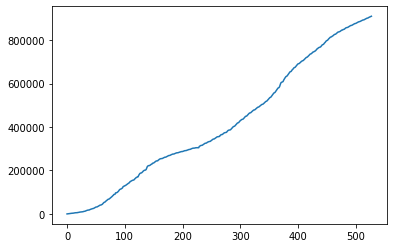

In [184]:
covid_cases['casos_recuperados'].plot()

In [185]:
import lmfit

In [186]:

from datetime import date

d0 = date(2020, 3, 27)
d1 = date(2021, 9, 5)
delta = d1 - d0
print(delta.days)

527


In [187]:
isolamento = pd.read_excel(r"C:\Users\mscamargo\Desktop\estudos\my_proj\covid19_previsoes_municipios\data\Dados.xlsx", engine = 'openpyxl')
isolamento = isolamento.melt(id_vars=['Município1',	'Código Município IBGE',	'População estimada (2020)'], value_name= 'isolamento', var_name= 'data')
isolamento =isolamento[isolamento.data != 'UF1']
isolamento.data = pd.to_datetime(isolamento.data)
isolamento['Código Município IBGE'] = isolamento['Código Município IBGE'].astype(float)

In [188]:
isolamento['Município1'] = isolamento['Município1'].str.lower()
covid_cases['municipio'] = covid_cases['municipio'].str.lower()

In [189]:
covid_cases = covid_cases.merge(isolamento[['Município1', 'data', 'isolamento']], right_on=  ['Município1', 'data'], left_on = ['municipio', 'data'], how= 'left')

In [190]:
NEW_STRAIN_DATE = '2021-01-01'
train_subset = covid_cases[
    #(df.date >= '2020-03-25') &
    (covid_cases.data <= NEW_STRAIN_DATE)]

In [191]:
from scipy.integrate import odeint

In [192]:

class BarebonesSEIR:
    def __init__(self, params=None):
        self.params = params

    def get_fit_params(self):
        params = lmfit.Parameters()
        params.add("population", value=12_252_023, vary=False)
        params.add("epidemic_started_days_ago", value=10, vary=False)
        params.add("r0", value=4, min=3, max=5, vary=True)
        params.add("alpha", value=0.0064, min=0.005, max=0.0078, vary=True)  # CFR
        params.add("delta", value=1/3, min=1/14, max=1/2, vary=True)  # E -> I rate
        params.add("gamma", value=1/9, min=1/14, max=1/7, vary=True)  # I -> R rate
        params.add("rho", expr='gamma', vary=False)  # I -> D rate
        return params

    def get_initial_conditions(self, data):
        # Simulate such initial params as to obtain as many deaths as in data
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, R, D) = self.predict(t, (population - 1, 0, 1, 0, 0))

        I0 = I[-1]
        E0 = E[-1]
        Rec0 = R[-1]
        D0 = D[-1]
        S0 = S[-1]
        return (S0, E0, I0, Rec0, D0)

    def step(self, initial_conditions, t):
        population = self.params['population']
        delta = self.params['delta']
        gamma = self.params['gamma']
        alpha = self.params['alpha']
        rho = self.params['rho']
        
        rt = self.params['r0'].value
        beta = rt * gamma

        S, E, I, R, D = initial_conditions

        new_exposed = beta * I * (S / population)
        new_infected = delta * E
        new_dead = alpha * rho * I
        new_recovered = gamma * (1 - alpha) * I

        dSdt = -new_exposed
        dEdt = new_exposed - new_infected
        dIdt = new_infected - new_recovered - new_dead
        dRdt = new_recovered
        dDdt = new_dead

        assert S + E + I + R + D - population <= 1e10
        assert dSdt + dIdt + dEdt + dRdt + dDdt <= 1e10
        return dSdt, dEdt, dIdt, dRdt, dDdt

    def predict(self, t_range, initial_conditions):
        ret = odeint(self.step, initial_conditions, t_range)
        return ret.T


In [193]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import pickle
import joblib
import matplotlib.dates as mdates

In [194]:

model = BarebonesSEIR()
model.params = model.get_fit_params()
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))
(S, E, I, R, D) = model.predict(train_t, train_initial_conditions)



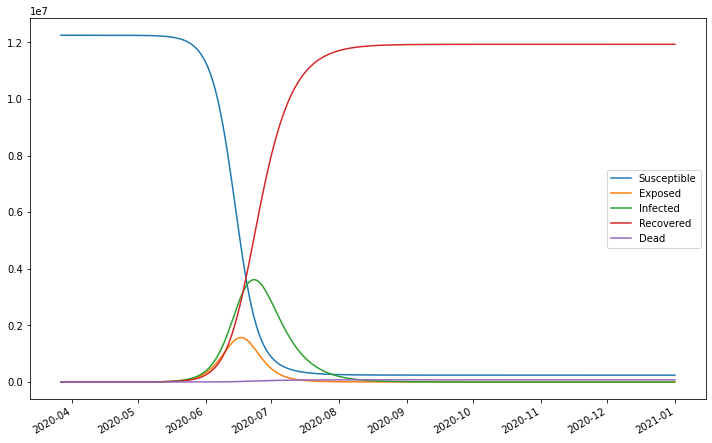

In [195]:
fig = plt.figure(figsize=(10,7))
plt.plot(train_subset.data, S, label='Susceptible')
plt.plot(train_subset.data, E, label='Exposed')
plt.plot(train_subset.data, I, label='Infected')
plt.plot(train_subset.data, R, label='Recovered')
plt.plot(train_subset.data, D, label='Dead')
plt.legend()
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

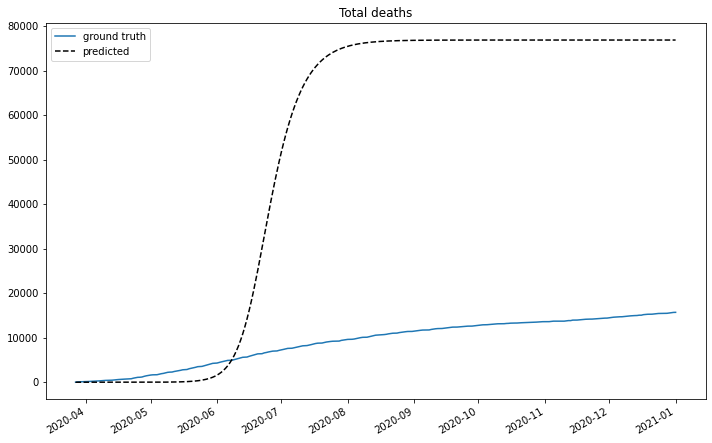

In [196]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_subset.data, train_subset['obitosAcumulado'], label='ground truth')
plt.plot(train_subset.data, D, label='predicted', color='black', linestyle='dashed' )
plt.legend()
plt.title('Total deaths')
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

## Modelagem Quarentena

In [197]:
covid_cases.shape

(528, 29)

In [198]:
train_subset.shape

(281, 29)

In [199]:
train_subset['media_movel_isolamento'] =train_subset['isolamento'].transform(lambda x: x.rolling(70, 1).mean())
print(train_subset.iloc[70].media_movel_isolamento, train_subset.iloc[140].media_movel_isolamento,train_subset.iloc[210].media_movel_isolamento,train_subset.iloc[280].media_movel_isolamento)

0.4920668063015873 0.4559501422878788 0.4346099562727273 0.4247345867121212


<ipython-input-199-fd208eae6f23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_subset['media_movel_isolamento'] =train_subset['isolamento'].transform(lambda x: x.rolling(70, 1).mean())


In [200]:
print(train_subset.iloc[70].media_movel_isolamento, train_subset.iloc[140].media_movel_isolamento,train_subset.iloc[210].media_movel_isolamento,train_subset.iloc[280].media_movel_isolamento)

0.4920668063015873 0.4559501422878788 0.4346099562727273 0.4247345867121212


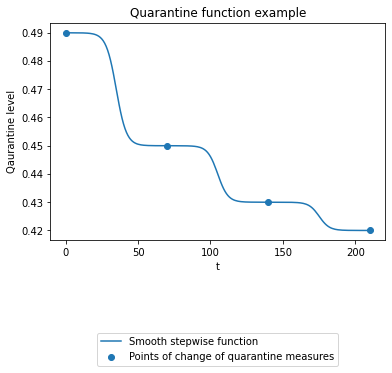

In [201]:
def sigmoid(x, xmin, xmax, a, b, c, r):
    x_scaled = (x - xmin) / (xmax - xmin)
    out = (a * np.exp(c * r) + b * np.exp(r * x_scaled)) / (np.exp(c * r) + np.exp(x_scaled * r))
    return out


def stepwise_soft(t, coefficients, r=20, c=0.5):
    t_arr = np.array(list(coefficients.keys()))

    min_index = np.min(t_arr)
    max_index = np.max(t_arr)

    if t <= min_index:
        return coefficients[min_index]
    elif t >= max_index:
        return coefficients[max_index]
    else:
        index = np.min(t_arr[t_arr >= t])

    if len(t_arr[t_arr < index]) == 0:
        return coefficients[index]
    prev_index = np.max(t_arr[t_arr < index])
    # sigmoid smoothing
    q0, q1 = coefficients[prev_index], coefficients[index]
    out = sigmoid(t, prev_index, index, q0, q1, c, r)
    return out

t_range = np.arange(210)
coefficients = {
    0: 0.49,
    70: 0.45,
    140: 0.43,
    210: 0.42,
}

plt.title('Quarantine function example')
plt.scatter(coefficients.keys(), coefficients.values(), label='Points of change of quarantine measures')
plt.plot(t_range, [stepwise_soft(t, coefficients, r=20, c=0.5) for t in t_range], label='Smooth stepwise function')
plt.xlabel('t')
plt.ylabel('Qaurantine level')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6),)
plt.show()

# Modelo com a quarentena modelada

In [202]:
from sir_models.fitters import HiddenCurveFitter
from sir_models.models import SEIRHidden

In [205]:
stepwize_size = 60

weights = {
    'I': 0.25,
    'R': 0.25,
    'D': 0.5,
}
model = SEIRHidden(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='media_movel_obitos',
     new_cases_col='media_movel_casos',
     new_recoveries_col='media_movel_recuperados',
     
     weights=weights,
     max_iters=300,
     save_params_every=50,
)
fitter.fit(model, train_subset)

 73%|███████▎  | 220/300 [01:10<00:25,  3.14it/s, Error=0.111]


In [206]:
result = fitter.result
result

In [207]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

In [210]:
daily_df = pd.DataFrame(
    {
        'date': train_subset.data[1:].values,
        'new_exposed': new_exposed,
        'new_infected_invisible': new_infected_invisible,
        'new_infected_visible': new_infected_visible,
        'new_recovered_invisible': new_recovered_invisible,
        'new_recovered_visible': new_recovered_visible,
        'new_dead_invisible': new_dead_invisible,
        'new_dead_visible': new_dead_visible
    },
    index=train_subset.data[1:])

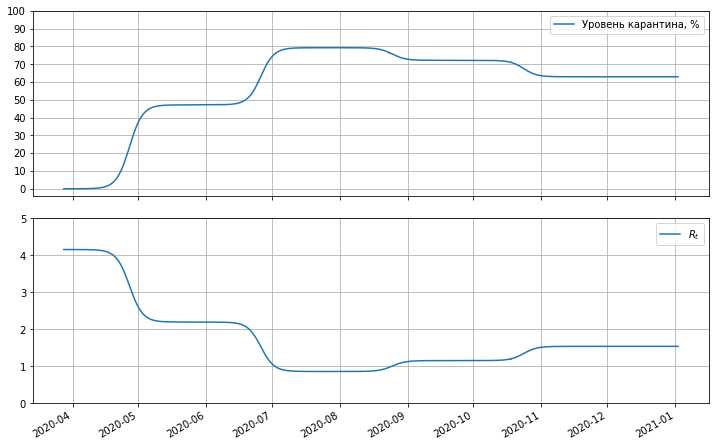

In [211]:
history_dates = covid_cases.data.iloc[0] + pd.to_timedelta(history.t, unit='days')

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2,1,1)
plt.plot(history_dates, history.quarantine_mult, label='Уровень карантина, %')
plt.legend()
plt.tight_layout()
y_ticks = list(np.arange(0, 1.1, 0.1).round(1))
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels([f'{int(100*t)}' for t in y_ticks])
plt.grid()

plt.subplot(2,1,2, sharex=ax1)
plt.plot(history_dates, history.rt, label='$R_t$')
plt.ylim(0, 5)
plt.grid()
plt.legend()

fig.autofmt_xdate()
plt.show()

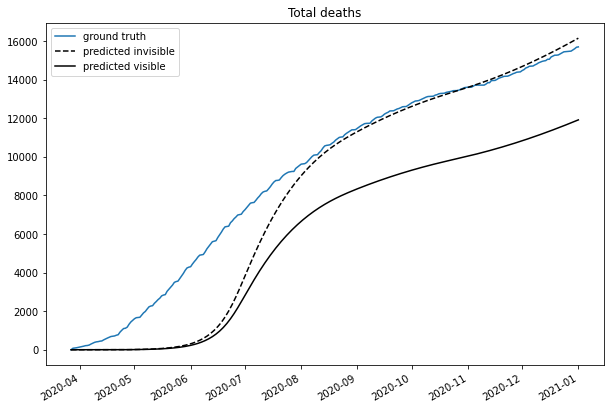

In [212]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_subset.data, train_subset['obitosAcumulado'], label='ground truth')
plt.plot(train_subset.data, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.data, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
fig.autofmt_xdate()
plt.show()

## Cross validaiton

In [230]:
from sir_models.utils import eval_on_select_dates_and_k_days_ahead, smape


In [261]:
covid_cases.data == 2021-08-06)

Timestamp('2021-09-05 00:00:00')

In [259]:
covid_cases.date.iloc[-1] - pd.to_timedelta(K, unit='D')

Timestamp('2021-08-06 00:00:00')

In [262]:
K = 30
last_day = covid_cases.date.iloc[-1] - pd.to_timedelta(K, unit='D')
eval_dates = pd.date_range(start='2020-06-01', end=last_day)[::20]
len(eval_dates)

22

In [264]:
def eval_hidden_moscow(train_df, t, train_t, eval_t):
    weights = {
        'I': 0.25,
        'R': 0.25,
        'D': 0.5,
    }
    model = SEIRHidden()
    fitter = HiddenCurveFitter(
     new_deaths_col='media_movel_obitos',
     new_cases_col='media_movel_casos',
     new_recoveries_col='media_movel_recuperados',
        weights=weights,
        max_iters=300,
        save_params_every=500)
    fitter.fit(model, train_df)

    train_initial_conditions = model.get_initial_conditions(train_df)
    train_states, history = model.predict(train_t, train_initial_conditions, history=False)

    test_initial_conds = [compartment[-1] for compartment in train_states]
    test_states, history = model.predict(eval_t, test_initial_conds, history=False)
        
    return model, fitter, test_states


In [265]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(covid_cases,
                                                                                     eval_func=eval_hidden_moscow, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 out of  22 | elapsed:  4.3min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  13 out of  22 | elapsed:  6.2min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  16 out of  22 | elapsed:  8.8min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:  9.6min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed: 11.1min finished


In [269]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]
model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.obitosAcumulado.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].obitosAcumulado]*K for tdf in train_dfs]
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]
overall_smape_model = [smape(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_model
print('MAE baseline', np.mean(overall_errors_baseline).round(3))
print('MAE model', np.mean(overall_errors_model).round(3))
print('SMAPE model', np.mean(overall_smape_model).round(3))
ix = np.random.choice(np.arange(len(train_dfs[-5:])))



MAE baseline 1130.861
MAE model 5553.951
SMAPE model 0.164


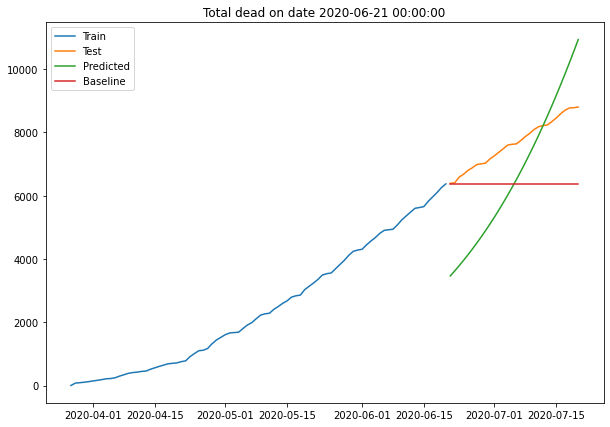

In [270]:
train_df = train_dfs[ix]
test_df = test_dfs[ix]
model_preds = model_predictions[ix]
baseline_predictions = baseline_pred_D[ix]
fitter = fitters[ix]
plt.figure(figsize=(10, 7))
plt.plot(train_df.date, train_df.obitosAcumulado, label='Train')
plt.plot(test_df.date, test_df.obitosAcumulado, label='Test')
plt.plot(test_df.date, model_preds[7], label='Predicted')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
plt.legend()
plt.title(f'Total dead on date {test_df.date.iloc[0]}')
plt.show()

In [ ]:
date_of_first_strain2_contact = '2021-01-10'

In [ ]:
covid_cases['recuperadosPorDia'] = covid_cases['casos_recuperados'].diff().fillna(covid_cases['casos_recuperados'].iloc[0])
covid_cases['media_movel_recuperados'] = covid_cases['recuperadosPorDia'].transform(lambda x: x.rolling(7, 1).mean())